# Predicting beer consumption

## Importing required modules

In [36]:
# Install packages for the project
#!pip install pandas numpy seaborn matplotlib scikit-learn scipy

In [37]:
#pip install seaborn

In [38]:
#pip install scikit-learn

In [39]:
# Import the required building blocks
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Beer consumption as a regression problem
Vamos prever diretamente a variável contínua **Litres**, ou seja, a quantidade de litros vendidos por dia.
Esse enquadramento transforma o estudo em um problema de regressão e permite medir os modelos com métricas como MAE, RMSE e R².


## Data analysis and preprocessing

In [40]:
# Back to the source
df = pd.read_csv('Beerconsumption.csv')

In [41]:
df.head()

,Date,AvgTemp,MinTemp,MaxTemp,Rainfall_mm,Weekend,Litres
0,2015-01-01,27.30,23.9,32.5,0.0,0,25461.0
1,2015-01-02,27.02,24.5,33.5,0.0,0,28972.0
2,2015-01-03,24.82,22.4,29.9,0.0,1,30814.0
3,2015-01-04,23.98,21.5,28.6,1.2,1,29799.0
4,2015-01-05,23.82,21.0,28.3,0.0,0,28900.0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         365 non-null    object 
 1   AvgTemp      365 non-null    float64
 2   MinTemp      365 non-null    float64
 3   MaxTemp      365 non-null    float64
 4   Rainfall_mm  365 non-null    float64
 5   Weekend      365 non-null    int64  
 6   Litres       365 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 20.1+ KB


In [43]:
df.describe()

,AvgTemp,MinTemp,MaxTemp,Rainfall_mm,Weekend,Litres
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.226356,17.461370,26.611507,5.196712,0.284932,25401.367123
std,3.180108,2.826185,4.317366,12.417844,0.452001,4399.142703
min,12.900000,10.600000,14.500000,0.000000,0.000000,14343.000000
25%,19.020000,15.300000,23.800000,0.000000,0.000000,22008.000000
50%,21.380000,17.900000,26.900000,0.000000,0.000000,24867.000000
75%,23.280000,19.600000,29.400000,3.200000,1.000000,28631.000000
max,28.860000,24.500000,36.500000,94.800000,1.000000,37937.000000


In [44]:
df.dropna(inplace=True)
df.Date = pd.to_datetime(df.Date)
df.Weekend = df.Weekend.astype(int)

array([[<Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'AvgTemp'}>,
        <Axes: title={'center': 'MinTemp'}>],
       [<Axes: title={'center': 'MaxTemp'}>,
        <Axes: title={'center': 'Rainfall_mm'}>,
        <Axes: title={'center': 'Weekend'}>],
       [<Axes: title={'center': 'Litres'}>, <Axes: >, <Axes: >]],
      dtype=object)

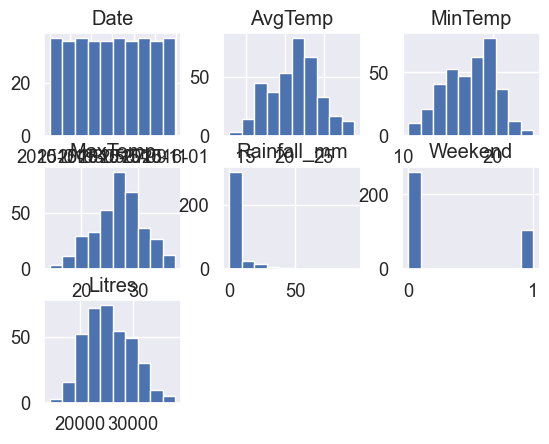

In [45]:
df.hist()

### Explorando a variável alvo
Antes de treinar os modelos, analisamos como `Litres` varia ao longo do tempo e das estações.


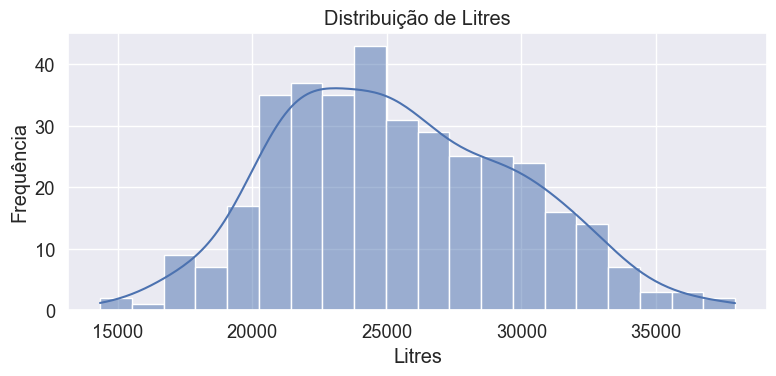

In [46]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Litres'], bins=20, kde=True)
plt.title('Distribuição de Litres')
plt.xlabel('Litres')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()


         count     mean     std
Weekend                        
0          261  23998.2  3787.5
1          104  28922.7  3830.2


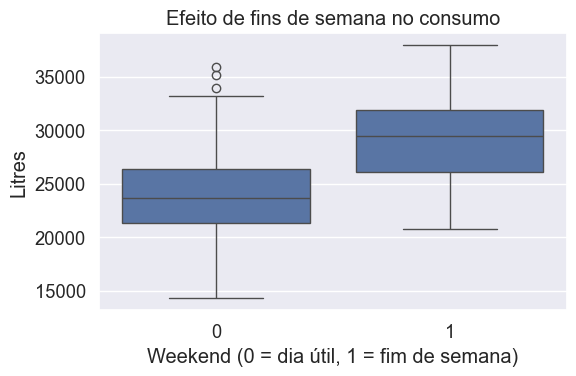

In [47]:
weekend_stats = df.groupby('Weekend')['Litres'].agg(['count', 'mean', 'std']).round(1)
print(weekend_stats)

plt.figure(figsize=(6, 4))
sns.boxplot(x='Weekend', y='Litres', data=df)
plt.title('Efeito de fins de semana no consumo')
plt.xlabel('Weekend (0 = dia útil, 1 = fim de semana)')
plt.ylabel('Litres')
plt.tight_layout()
plt.show()


### 1. Feature selection
Is the Date a useful feature for our goal? Would another be useful? How can you check?

In [48]:
# Let's add the season, because why not
df['Season'] = df.Date.dt.month.map({1:1, 2:1, 3:2, 4:2, 5:2, 6:3, 7:3, 8:3, 9:4, 10:4, 11:4, 12:1})

In [49]:
df['Month'] = df.Date.dt.month

In [50]:
df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

df["Weekday"] = df["Date"].dt.dayofweek + 1
df["Weekday_sin"] = np.cos(2 * np.pi * df["Weekday"] / 7)
df["Weekday_cos"] = np.cos(2 * np.pi * df["Weekday"] / 7)

In [51]:
#pip install holidays

In [52]:
import pandas as pd
import holidays

# dataframe com coluna Date em datetime
df["Date"] = pd.to_datetime(df["Date"])

# instância da lista de feriados — por exemplo, Brasil
br_holidays = holidays.Brazil()

# cria a coluna binária
df["HolyDay"] = df["Date"].apply(lambda d: 1 if d in br_holidays else 0)

In [53]:
df.tail()

,Date,AvgTemp,MinTemp,MaxTemp,Rainfall_mm,Weekend,Litres,Season,Month,Month_sin,Month_cos,Weekday,Weekday_sin,Weekday_cos,HolyDay
360,2015-12-27,24.00,21.1,28.2,13.6,1,32307.0,1,12,-2.449294e-16,1.0,7,1.000000,1.000000,0
361,2015-12-28,22.64,21.1,26.7,0.0,0,26095.0,1,12,-2.449294e-16,1.0,1,0.623490,0.623490,0
362,2015-12-29,21.68,20.3,24.1,10.3,0,22309.0,1,12,-2.449294e-16,1.0,2,-0.222521,-0.222521,0
363,2015-12-30,21.38,19.3,22.4,6.3,0,20467.0,1,12,-2.449294e-16,1.0,3,-0.900969,-0.900969,0
364,2015-12-31,24.76,20.2,29.0,0.0,0,22446.0,1,12,-2.449294e-16,1.0,4,-0.900969,-0.900969,0


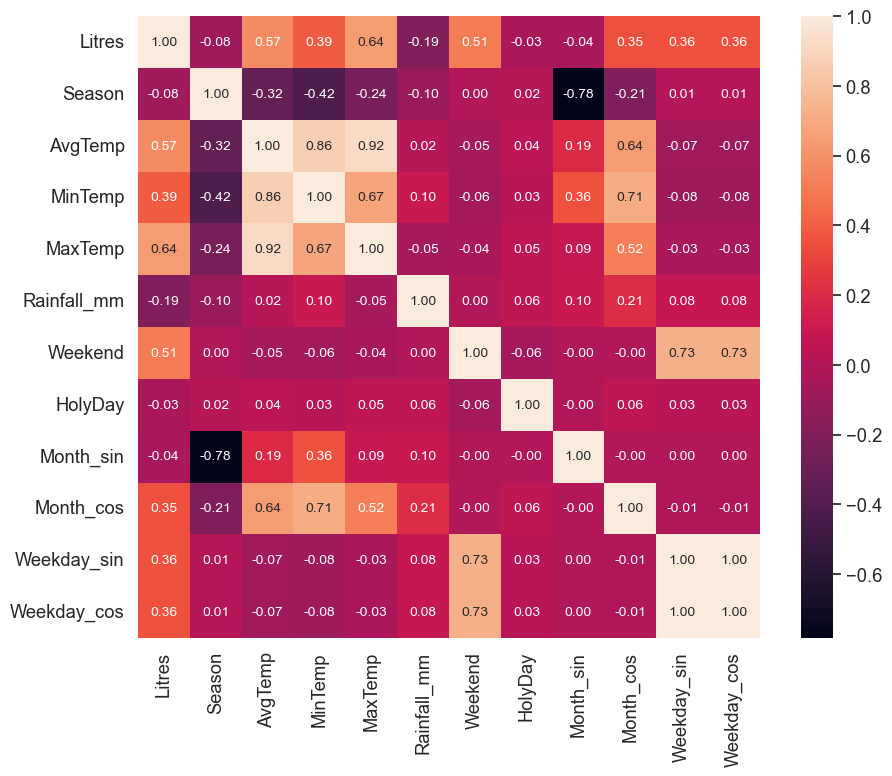

In [54]:
# Plot the correlation matrix for selected features
kolomdf = ['Litres', 'Season', 'AvgTemp', 'MinTemp', 'MaxTemp', 'Rainfall_mm', 'Weekend', 'HolyDay', 'Month_sin', 'Month_cos', 'Weekday_sin', 'Weekday_cos']

plt.figure(figsize=(10, 8))
cm = np.corrcoef(df[kolomdf].values.T)
sns.set(font_scale=1.2)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 10},
                yticklabels=kolomdf,
                xticklabels=kolomdf
                )
plt.tight_layout()
plt.show()


Selecionaremos variáveis climáticas e de calendário (temperaturas, chuva, fim de semana, feriado e codificações sazonais) para prever `Litres`.


In [55]:
feature_cols = ['MaxTemp', 'MinTemp', 'AvgTemp', 'Rainfall_mm', 'Weekend', 'Season', 'HolyDay', 'Month_sin', 'Month_cos', 'Weekday_sin', 'Weekday_cos']
data = df.loc[:, feature_cols]
labels = df.loc[:, 'Litres']

print('Features utilizadas:', feature_cols)
data.head()


Features utilizadas: ['MaxTemp', 'MinTemp', 'AvgTemp', 'Rainfall_mm', 'Weekend', 'Season', 'HolyDay', 'Month_sin', 'Month_cos', 'Weekday_sin', 'Weekday_cos']


,MaxTemp,MinTemp,AvgTemp,Rainfall_mm,Weekend,Season,HolyDay,Month_sin,Month_cos,Weekday_sin,Weekday_cos
0,32.5,23.9,27.30,0.0,0,1,1,0.5,0.866025,-0.900969,-0.900969
1,33.5,24.5,27.02,0.0,0,1,0,0.5,0.866025,-0.222521,-0.222521
2,29.9,22.4,24.82,0.0,1,1,0,0.5,0.866025,0.623490,0.623490
3,28.6,21.5,23.98,1.2,1,1,0,0.5,0.866025,1.000000,1.000000
4,28.3,21.0,23.82,0.0,0,1,0,0.5,0.866025,0.623490,0.623490


# Função que calcula métricas de regressão


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def regression_report(y_true, y_pred, model_name="Model"):
    """Exibe MAE, RMSE e R² e gera o gráfico de valores previstos vs. reais.

    Parameters
    ----------
    y_true : array-like
        Valores reais.
    y_pred : array-like
        Valores previstos pelo modelo.
    model_name : str
        Nome do modelo para aparecer no título do gráfico.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} -> MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

    plt.figure(figsize=(5, 5))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)
    diagonal = np.linspace(min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max()), 100)
    plt.plot(diagonal, diagonal, 'r--', label='Predição perfeita')
    plt.xlabel('Valor real (Litres)')
    plt.ylabel('Valor previsto (Litres)')
    plt.title(f'Valores reais vs previstos - {model_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {"MAE": mae, "RMSE": rmse, "R2": r2}


## 2. Baseline models for regression
Code a baseline regression model


In [57]:
# splits the dataset in a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    labels, 
                                                    test_size=0.25, 
                                                    random_state=0)

results = {}

# give the size of the training and the test set again
print('shape of training set: ', X_train.shape)
print('shape of test set:     ', X_test.shape)


shape of training set:  (273, 11)
shape of test set:      (92, 11)


LinearRegression -> MAE: 1989.31 | RMSE: 2350.09 | R²: 0.671


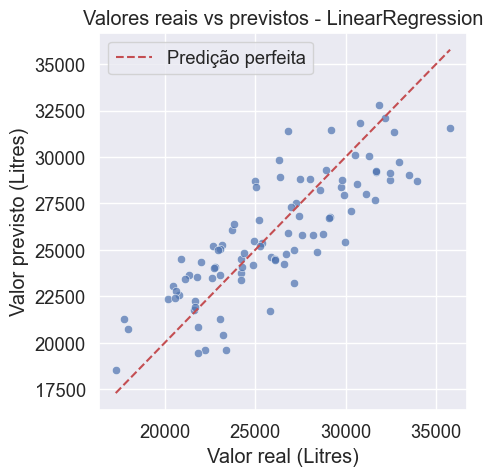

In [58]:
from sklearn.linear_model import LinearRegression

# 2.1 Escolha um modelo base de regressão
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

lin_pred = lin_model.predict(X_test)
results['LinearRegression'] = regression_report(y_test, lin_pred, model_name='LinearRegression')


KNeighborsRegressor -> MAE: 2528.89 | RMSE: 3072.89 | R²: 0.437


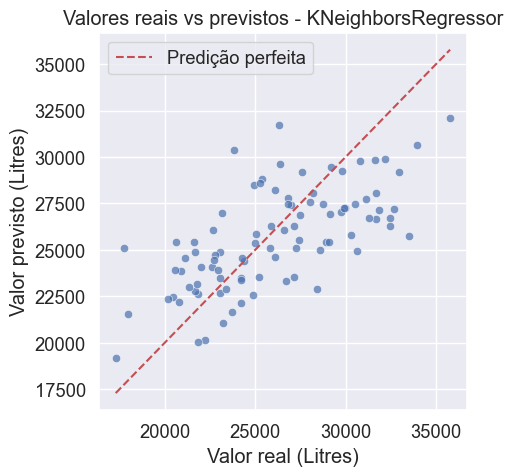

In [59]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

knn_pred = knn_model.predict(X_test)
results['KNeighborsRegressor'] = regression_report(y_test, knn_pred, model_name='KNeighborsRegressor')


#### Question: como os modelos lineares/paramétricos se comparam? Eles capturam bem as nuances do consumo?


## 3/4. Tree-based regression models
Code a decision tree and random forest below!


DecisionTreeRegressor -> MAE: 2547.32 | RMSE: 3138.40 | R²: 0.413


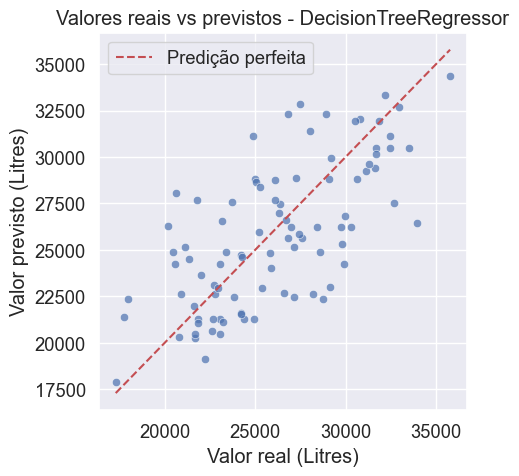

In [60]:
from sklearn.tree import DecisionTreeRegressor

# Fill in the blank with a decision tree model
dt_model = DecisionTreeRegressor(random_state=42)

dt_model.fit(X_train, y_train)

dt_pred = dt_model.predict(X_test)
results['DecisionTreeRegressor'] = regression_report(y_test, dt_pred, model_name='DecisionTreeRegressor')


RandomForestRegressor -> MAE: 1964.96 | RMSE: 2355.27 | R²: 0.669


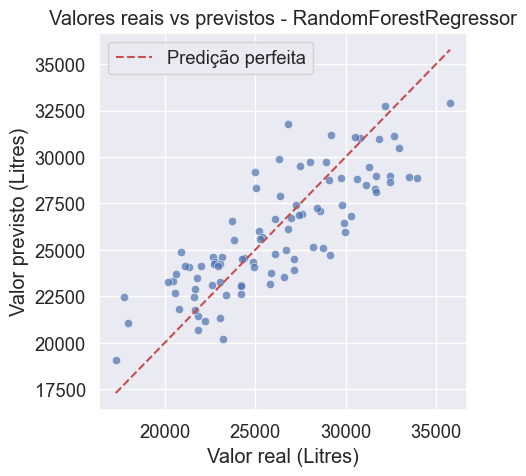

In [61]:
from sklearn.ensemble import RandomForestRegressor

# Fill in the blank with a random forest model
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)

rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
results['RandomForestRegressor'] = regression_report(y_test, rf_pred, model_name='RandomForestRegressor')


In [62]:
for model_name, metrics in results.items():
    print(f"{model_name}: MAE={metrics['MAE']:.2f} | RMSE={metrics['RMSE']:.2f} | R²={metrics['R2']:.3f}")


LinearRegression: MAE=1989.31 | RMSE=2350.09 | R²=0.671
KNeighborsRegressor: MAE=2528.89 | RMSE=3072.89 | R²=0.437
DecisionTreeRegressor: MAE=2547.32 | RMSE=3138.40 | R²=0.413
RandomForestRegressor: MAE=1964.96 | RMSE=2355.27 | R²=0.669
